In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from os.path import join, exists
from matplotlib.colors import LogNorm
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from sklearn.model_selection import GroupKFold
from tensorflow.keras.optimizers import Adam

In [2]:
summary_file = "/glade/scratch/siyuan/POSTPROCESSING/ML2019_toluene_kOH/Batch1_toluene/GAR0084_Exp_List_TEXT_PreCompile_BatchSubmit_v0.csv"
summary_data = pd.read_csv(summary_file, skiprows=3)
summary_data.columns = summary_data.columns.str.strip()
summary_data.columns
summary_data["idnum"] = summary_data.index

In [3]:
def load_data(path, summary_file, species="toluene_kOH"):
    """
    Load a set of experiment files based on a summary file.
    
    Args:
        path: Path to the directory containing summary and experiment files
        summary_file: Name of the summary file (should not contain the path)
        species: Name of the precursor chemical species
    
    Returns:
        exp_data_merged: All time series data for every experiment in pandas DataFrame
        summary_data: Summary experiment data file in pandas DataFrame
    """
    summary_data = pd.read_csv(join(path, summary_file), skiprows=3)
    summary_data.columns = summary_data.columns.str.strip()
    summary_data["idnum"] = summary_data.index
    exp_data_list = []
    for i, id_val in enumerate(summary_data["id"]):
        if i % 100 == 0:
            print(id_val)
        exp_file = join(path, f"ML2019_{species}_ML2019_{id_val}.csv")
        exp_data_list.append(pd.read_csv(exp_file))
        exp_data_list[-1]["id"] = id_val
        exp_data_list[-1]["idnum"] = i
        exp_data_list[-1]["timestep"] = np.arange(exp_data_list[-1].shape[0])
    exp_data_combined = pd.concat(exp_data_list, ignore_index=True)
    exp_data_combined.columns = exp_data_combined.columns.str.strip()
    exp_data_merged = pd.merge(exp_data_combined, summary_data, left_on="idnum", right_on="idnum")
    print(exp_data_combined.columns)
    return exp_data_merged, summary_data

In [4]:
exp_data_merged, summary_data = load_data("/glade/work/dgagne/Batch1_toluene", 
                                          "GAR0084_Exp_List_TEXT_PreCompile_BatchSubmit_v0.csv")

Exp0
Exp100
Exp200
Exp300
Exp400
Exp500
Exp600
Exp700
Exp800
Exp900
Exp1000
Exp1100
Exp1200
Exp1300
Exp1400
Exp1500
Exp1600
Exp1700
Exp1800
Exp1900
Exp2000
Exp2100
Exp2200
Exp2300
Exp2400
Exp2500
Exp2600
Exp2700
Exp2800
Exp2900
Exp3000
Exp3100
Exp3200
Exp3300
Exp3400
Exp3500
Exp3600
Exp3700
Exp3800
Exp3900
Exp4000
Exp4100
Exp4200
Exp4300
Exp4400
Exp4500
Exp4600
Exp4700
Exp4800
Exp4900
Exp5000
Exp5100
Exp5200
Exp5300
Index(['Time [s]', 'Precursor [ug/m3]', 'Gas [ug/m3] Bin01: lg(C*) = -5.5',
       'Gas [ug/m3] Bin02: lg(C*) = -4.5', 'Gas [ug/m3] Bin03: lg(C*) = -3.5',
       'Gas [ug/m3] Bin04: lg(C*) = -2.5', 'Gas [ug/m3] Bin05: lg(C*) = -1.5',
       'Gas [ug/m3] Bin06: lg(C*) = -0.5', 'Gas [ug/m3] Bin07: lg(C*) =  0.5',
       'Gas [ug/m3] Bin08: lg(C*) =  1.5',
       ...
       'N/C Bin08: lg(C*) =  1.5', 'N/C Bin09: lg(C*) =  2.5',
       'N/C Bin10: lg(C*) =  3.5', 'N/C Bin11: lg(C*) =  4.5',
       'N/C Bin12: lg(C*) =  5.5', 'N/C Bin13: lg(C*) =  6.5',
       'N/C Bin14: lg(C*

In [5]:
exp_data_merged.loc[exp_data_merged["idnum"] == 10]

,Time [s],Precursor [ug/m3],Gas [ug/m3] Bin01: lg(C*) = -5.5,Gas [ug/m3] Bin02: lg(C*) = -4.5,Gas [ug/m3] Bin03: lg(C*) = -3.5,Gas [ug/m3] Bin04: lg(C*) = -2.5,Gas [ug/m3] Bin05: lg(C*) = -1.5,Gas [ug/m3] Bin06: lg(C*) = -0.5,Gas [ug/m3] Bin07: lg(C*) = 0.5,Gas [ug/m3] Bin08: lg(C*) = 1.5,...,id_x,idnum,timestep,id_y,temperature (K),solar zenith angle (degree),pre-existing aerosols (ug/m3),o3 (ppb),nox (ppb),oh (10^6 molec/cm3)
5760,1.000000,0.037689,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,Exp10,10,0,Exp10,270.0,0.0,0.01,1.0,1.0,5.0
5761,301.519989,0.037332,1.113952e-21,4.070264e-20,6.686731e-17,1.389201e-16,4.066288e-15,1.757855e-13,9.118843e-12,5.212791e-12,...,Exp10,10,1,Exp10,270.0,0.0,0.01,1.0,1.0,5.0
5762,602.039978,0.036979,8.465895e-21,2.655437e-19,1.143732e-16,1.790802e-15,2.412341e-14,4.494002e-12,6.651374e-11,3.789099e-11,...,Exp10,10,2,Exp10,270.0,0.0,0.01,1.0,1.0,5.0
5763,902.559998,0.036628,3.248028e-20,7.934065e-19,2.488888e-15,9.371479e-15,1.919735e-13,2.865727e-11,2.018920e-10,1.266861e-10,...,Exp10,10,3,Exp10,270.0,0.0,0.01,1.0,1.0,5.0
5764,1203.079956,0.036281,1.030769e-19,2.069284e-18,3.476972e-15,2.874213e-14,4.096286e-13,1.022437e-10,4.320647e-10,2.948841e-10,...,Exp10,10,4,Exp10,270.0,0.0,0.01,1.0,1.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6331,171597.921875,0.000165,1.043278e-13,1.525949e-12,1.460513e-10,1.237334e-09,3.408873e-08,1.015127e-06,4.097190e-07,9.564674e-09,...,Exp10,10,571,Exp10,270.0,0.0,0.01,1.0,1.0,5.0
6332,171898.437500,0.000163,1.041344e-13,1.523302e-12,1.458010e-10,1.234989e-09,3.408640e-08,1.008500e-06,4.094157e-07,9.512465e-09,...,Exp10,10,572,Exp10,270.0,0.0,0.01,1.0,1.0,5.0
6333,172198.953125,0.000162,1.039410e-13,1.520657e-12,1.455456e-10,1.232646e-09,3.408390e-08,1.001909e-06,4.091112e-07,9.417578e-09,...,Exp10,10,573,Exp10,270.0,0.0,0.01,1.0,1.0,5.0
6334,172499.484375,0.000160,1.037479e-13,1.518013e-12,1.452935e-10,1.230307e-09,3.408143e-08,9.953547e-07,4.088050e-07,9.325147e-09,...,Exp10,10,574,Exp10,270.0,0.0,0.01,1.0,1.0,5.0


In [6]:
input_exp_cols = ['Precursor [ug/m3]',
    'Gas [ug/m3] Bin01: lg(C*) = -5.5',
    'Gas [ug/m3] Bin02: lg(C*) = -4.5',
    'Gas [ug/m3] Bin03: lg(C*) = -3.5',
    'Gas [ug/m3] Bin04: lg(C*) = -2.5',
    'Gas [ug/m3] Bin05: lg(C*) = -1.5',
    'Gas [ug/m3] Bin06: lg(C*) = -0.5',
    'Gas [ug/m3] Bin07: lg(C*) =  0.5',
    'Gas [ug/m3] Bin08: lg(C*) =  1.5',
    'Gas [ug/m3] Bin09: lg(C*) =  2.5',
    'Gas [ug/m3] Bin10: lg(C*) =  3.5',
    'Gas [ug/m3] Bin11: lg(C*) =  4.5',
    'Gas [ug/m3] Bin12: lg(C*) =  5.5',
    'Gas [ug/m3] Bin13: lg(C*) =  6.5',
    'Gas [ug/m3] Bin14: lg(C*) = -6.5',
    'Aerosol [ug_m3] Bin01: lg(C*) = -5.5',
    'Aerosol [ug_m3] Bin02: lg(C*) = -4.5',
    'Aerosol [ug_m3] Bin03: lg(C*) = -3.5',
    'Aerosol [ug_m3] Bin04: lg(C*) = -2.5',
    'Aerosol [ug_m3] Bin05: lg(C*) = -1.5',
    'Aerosol [ug_m3] Bin06: lg(C*) = -0.5',
    'Aerosol [ug_m3] Bin07: lg(C*) =  0.5',
    'Aerosol [ug_m3] Bin08: lg(C*) =  1.5',
    'Aerosol [ug_m3] Bin09: lg(C*) =  2.5',
    'Aerosol [ug_m3] Bin10: lg(C*) =  3.5',
    'Aerosol [ug_m3] Bin11: lg(C*) =  4.5',
    'Aerosol [ug_m3] Bin12: lg(C*) =  5.5',
    'Aerosol [ug_m3] Bin13: lg(C*) =  6.5',
    'Aerosol [ug_m3] Bin14: lg(C*) = -6.5',
    'temperature (K)',
    'solar zenith angle (degree)',
    'pre-existing aerosols (ug/m3)',
    'o3 (ppb)',
    'nox (ppb)',
    'oh (10^6 molec/cm3)',
    "idnum", 'timestep']

output_exp_cols = ['Precursor [ug/m3]',
    'Gas [ug/m3] Bin01: lg(C*) = -5.5',
    'Gas [ug/m3] Bin02: lg(C*) = -4.5',
    'Gas [ug/m3] Bin03: lg(C*) = -3.5',
    'Gas [ug/m3] Bin04: lg(C*) = -2.5',
    'Gas [ug/m3] Bin05: lg(C*) = -1.5',
    'Gas [ug/m3] Bin06: lg(C*) = -0.5',
    'Gas [ug/m3] Bin07: lg(C*) =  0.5',
    'Gas [ug/m3] Bin08: lg(C*) =  1.5',
    'Gas [ug/m3] Bin09: lg(C*) =  2.5',
    'Gas [ug/m3] Bin10: lg(C*) =  3.5',
    'Gas [ug/m3] Bin11: lg(C*) =  4.5',
    'Gas [ug/m3] Bin12: lg(C*) =  5.5',
    'Gas [ug/m3] Bin13: lg(C*) =  6.5',
    'Gas [ug/m3] Bin14: lg(C*) = -6.5',
    'Aerosol [ug_m3] Bin01: lg(C*) = -5.5',
    'Aerosol [ug_m3] Bin02: lg(C*) = -4.5',
    'Aerosol [ug_m3] Bin03: lg(C*) = -3.5',
    'Aerosol [ug_m3] Bin04: lg(C*) = -2.5',
    'Aerosol [ug_m3] Bin05: lg(C*) = -1.5',
    'Aerosol [ug_m3] Bin06: lg(C*) = -0.5',
    'Aerosol [ug_m3] Bin07: lg(C*) =  0.5',
    'Aerosol [ug_m3] Bin08: lg(C*) =  1.5',
    'Aerosol [ug_m3] Bin09: lg(C*) =  2.5',
    'Aerosol [ug_m3] Bin10: lg(C*) =  3.5',
    'Aerosol [ug_m3] Bin11: lg(C*) =  4.5',
    'Aerosol [ug_m3] Bin12: lg(C*) =  5.5',
    'Aerosol [ug_m3] Bin13: lg(C*) =  6.5',
    'Aerosol [ug_m3] Bin14: lg(C*) = -6.5',
    "idnum", 'timestep']

In [7]:
input_data_list = []
output_data_list = []
for exp in np.unique(exp_data_merged.idnum):
    if exp % 100 == 0:
        print(exp)
    input_data_list.append(exp_data_merged.loc[exp_data_merged.idnum==exp, input_exp_cols].reset_index(drop=True).iloc[:-1])
    output_data_list.append(exp_data_merged.loc[exp_data_merged.idnum==exp, output_exp_cols].reset_index(drop=True).iloc[1:])
input_data = pd.concat(input_data_list, ignore_index=True)
output_data = pd.concat(output_data_list, ignore_index=True)


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300


In [8]:
# Import Prediction Data
trial_num = "13"
    
prediction_file = "/glade/work/keelyl/trial_%s.csv" % trial_num
prediction_data = pd.read_csv(prediction_file)
prediction_data['timestep']= output_data.timestep


In [9]:
col = output_data.columns[output_data.columns.str.contains("")]
print(col)

Index(['Precursor [ug/m3]', 'Gas [ug/m3] Bin01: lg(C*) = -5.5',
       'Gas [ug/m3] Bin02: lg(C*) = -4.5', 'Gas [ug/m3] Bin03: lg(C*) = -3.5',
       'Gas [ug/m3] Bin04: lg(C*) = -2.5', 'Gas [ug/m3] Bin05: lg(C*) = -1.5',
       'Gas [ug/m3] Bin06: lg(C*) = -0.5', 'Gas [ug/m3] Bin07: lg(C*) =  0.5',
       'Gas [ug/m3] Bin08: lg(C*) =  1.5', 'Gas [ug/m3] Bin09: lg(C*) =  2.5',
       'Gas [ug/m3] Bin10: lg(C*) =  3.5', 'Gas [ug/m3] Bin11: lg(C*) =  4.5',
       'Gas [ug/m3] Bin12: lg(C*) =  5.5', 'Gas [ug/m3] Bin13: lg(C*) =  6.5',
       'Gas [ug/m3] Bin14: lg(C*) = -6.5',
       'Aerosol [ug_m3] Bin01: lg(C*) = -5.5',
       'Aerosol [ug_m3] Bin02: lg(C*) = -4.5',
       'Aerosol [ug_m3] Bin03: lg(C*) = -3.5',
       'Aerosol [ug_m3] Bin04: lg(C*) = -2.5',
       'Aerosol [ug_m3] Bin05: lg(C*) = -1.5',
       'Aerosol [ug_m3] Bin06: lg(C*) = -0.5',
       'Aerosol [ug_m3] Bin07: lg(C*) =  0.5',
       'Aerosol [ug_m3] Bin08: lg(C*) =  1.5',
       'Aerosol [ug_m3] Bin09: lg(C*) =  2.

In [ ]:
# ~~ Aerosol Calculations ~~

In [10]:
aer_output_data = output_data[['Aerosol [ug_m3] Bin01: lg(C*) = -5.5',
       'Aerosol [ug_m3] Bin02: lg(C*) = -4.5',
       'Aerosol [ug_m3] Bin03: lg(C*) = -3.5',
       'Aerosol [ug_m3] Bin04: lg(C*) = -2.5',
       'Aerosol [ug_m3] Bin05: lg(C*) = -1.5',
       'Aerosol [ug_m3] Bin06: lg(C*) = -0.5',
       'Aerosol [ug_m3] Bin07: lg(C*) =  0.5',
       'Aerosol [ug_m3] Bin08: lg(C*) =  1.5',
       'Aerosol [ug_m3] Bin09: lg(C*) =  2.5',
       'Aerosol [ug_m3] Bin10: lg(C*) =  3.5',
       'Aerosol [ug_m3] Bin11: lg(C*) =  4.5',
       'Aerosol [ug_m3] Bin12: lg(C*) =  5.5',
       'Aerosol [ug_m3] Bin13: lg(C*) =  6.5',
       'Aerosol [ug_m3] Bin14: lg(C*) = -6.5',
        'timestep']].copy()

In [11]:
aer_predict_data = prediction_data[['Aerosol [ug_m3] Bin01: lg(C*) = -5.5',
       'Aerosol [ug_m3] Bin02: lg(C*) = -4.5',
       'Aerosol [ug_m3] Bin03: lg(C*) = -3.5',
       'Aerosol [ug_m3] Bin04: lg(C*) = -2.5',
       'Aerosol [ug_m3] Bin05: lg(C*) = -1.5',
       'Aerosol [ug_m3] Bin06: lg(C*) = -0.5',
       'Aerosol [ug_m3] Bin07: lg(C*) =  0.5',
       'Aerosol [ug_m3] Bin08: lg(C*) =  1.5',
       'Aerosol [ug_m3] Bin09: lg(C*) =  2.5',
       'Aerosol [ug_m3] Bin10: lg(C*) =  3.5',
       'Aerosol [ug_m3] Bin11: lg(C*) =  4.5',
       'Aerosol [ug_m3] Bin12: lg(C*) =  5.5',
       'Aerosol [ug_m3] Bin13: lg(C*) =  6.5',
       'Aerosol [ug_m3] Bin14: lg(C*) = -6.5',
        'timestep']].copy()

         aer_total_output  aer_total_pred  aer_total_persist  timestep  \
0            2.764564e-11   -7.281550e-07       0.000000e+00         1   
1            2.075124e-10   -6.285628e-07       2.764564e-11         2   
2            8.419410e-10   -5.524120e-07       2.075124e-10         3   
3            2.192467e-09   -4.906859e-07       8.419410e-10         4   
4            4.469053e-09   -4.819269e-07       2.192467e-09         5   
...                   ...             ...                ...       ...   
3104995      1.513299e-03    1.479023e-03       1.502900e-03       571   
3104996      1.523792e-03    1.489017e-03       1.513299e-03       572   
3104997      1.534377e-03    1.499102e-03       1.523792e-03       573   
3104998      1.545047e-03    1.509275e-03       1.534377e-03       574   
3104999      1.555800e-03    1.519531e-03       1.545047e-03       575   

         aer_rmse_prediction  aer_rmse_persistance  
0               5.302500e-13          7.642816e-22  
1    

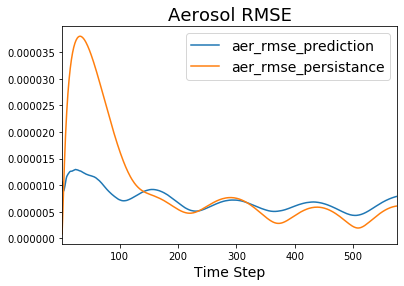

In [25]:
#Aer RMSE plots
aer_columns = aer_output_data.columns[aer_output_data.columns.str.contains("Aerosol")]
total_aer_df = pd.DataFrame({"aer_total_output": aer_output_data[aer_columns].sum(axis = 1),
                             "aer_total_pred": aer_predict_data[aer_columns].sum(axis = 1),
                             "aer_total_persist": input_data[aer_columns].sum(axis = 1),
                             'timestep': aer_output_data.timestep})
total_aer_df["aer_rmse_prediction"] = (total_aer_df.aer_total_output - total_aer_df.aer_total_pred)**2
total_aer_df["aer_rmse_persistance"] = (total_aer_df.aer_total_output - total_aer_df.aer_total_persist)**2
print(total_aer_df)

aer_rmse_time = total_aer_df.groupby(by = 'timestep')[["aer_rmse_prediction", "aer_rmse_persistance"]].mean()**0.5
print(aer_rmse_time)
aer_rmse_time.plot()
plt.title("Aerosol RMSE", fontsize=18)
plt.xlabel("Time Step", fontsize=14)
plt.legend(fontsize=14)
plt.savefig("rmse_plot_aer_trial_%s.png" % trial_num, dpi=200, bbox_inches="tight")

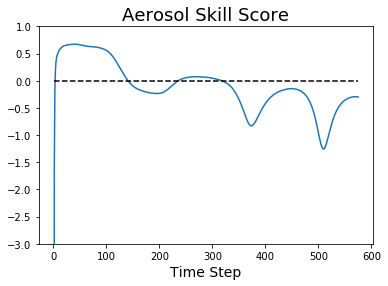

In [13]:
#Aer Skill Score

aer_rmse_time["aerosol_skill_score"] = (1 - (aer_rmse_time.aer_rmse_prediction / aer_rmse_time.aer_rmse_persistance))
plt.plot(aer_rmse_time.index , aer_rmse_time['aerosol_skill_score'])
plt.ylim(bottom = -3, top = 1)
plt.title("Aerosol Skill Score", fontsize=18)
plt.xlabel("Time Step", fontsize=14)
plt.plot(aer_rmse_time.index , np.zeros(aer_rmse_time.index.size), "k--")
plt.savefig("skill_plot_aer_trial_%s.png" % trial_num, dpi=200, bbox_inches="tight")

-1.6286580984002597e-07
          aer_total_pred  aer_total_output
timestep                                  
1               0.000003      2.743967e-07
2               0.000004      1.553841e-06
3               0.000006      4.123594e-06
4               0.000009      7.993400e-06
5               0.000014      1.309057e-05
...                  ...               ...
571             0.001794      1.797386e-03
572             0.001798      1.801046e-03
573             0.001801      1.804724e-03
574             0.001805      1.808417e-03
575             0.001809      1.812125e-03

[575 rows x 2 columns]


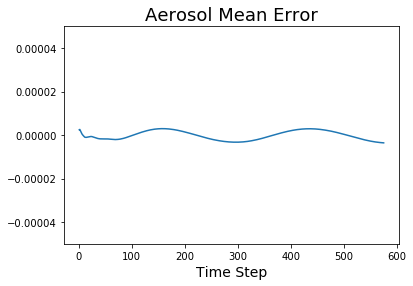

In [14]:
#Aer Average Mean
aer_mean_error = np.mean(aer_predict_data[aer_columns].sum(axis = 1) - aer_output_data[aer_columns].sum(axis = 1))
print(aer_mean_error)

aer_mean_df = total_aer_df.groupby(by = 'timestep')[["aer_total_pred", "aer_total_output"]].mean()
print(aer_mean_df)
aer_mean_df["aer_mean_error_pt"] = (aer_mean_df.aer_total_pred - aer_mean_df.aer_total_output)
plt.plot(aer_mean_df.index , aer_mean_df['aer_mean_error_pt'])
plt.ylim(bottom = -0.00005 , top = 0.00005)
plt.title("Aerosol Mean Error", fontsize=18)
plt.xlabel("Time Step", fontsize=14)
plt.savefig("mean_aer_trial_%s.png" % trial_num, dpi=200, bbox_inches="tight")

In [ ]:
# ~~ Gas Calculations ~~

In [15]:
gas_output_data = output_data[['Gas [ug/m3] Bin01: lg(C*) = -5.5',
       'Gas [ug/m3] Bin02: lg(C*) = -4.5', 'Gas [ug/m3] Bin03: lg(C*) = -3.5',
       'Gas [ug/m3] Bin04: lg(C*) = -2.5', 'Gas [ug/m3] Bin05: lg(C*) = -1.5',
       'Gas [ug/m3] Bin06: lg(C*) = -0.5', 'Gas [ug/m3] Bin07: lg(C*) =  0.5',
       'Gas [ug/m3] Bin08: lg(C*) =  1.5', 'Gas [ug/m3] Bin09: lg(C*) =  2.5',
       'Gas [ug/m3] Bin10: lg(C*) =  3.5', 'Gas [ug/m3] Bin11: lg(C*) =  4.5',
       'Gas [ug/m3] Bin12: lg(C*) =  5.5', 'Gas [ug/m3] Bin13: lg(C*) =  6.5',
       'Gas [ug/m3] Bin14: lg(C*) = -6.5',
        'timestep']].copy()

In [16]:
gas_predict_data = prediction_data[['Gas [ug/m3] Bin01: lg(C*) = -5.5',
       'Gas [ug/m3] Bin02: lg(C*) = -4.5', 'Gas [ug/m3] Bin03: lg(C*) = -3.5',
       'Gas [ug/m3] Bin04: lg(C*) = -2.5', 'Gas [ug/m3] Bin05: lg(C*) = -1.5',
       'Gas [ug/m3] Bin06: lg(C*) = -0.5', 'Gas [ug/m3] Bin07: lg(C*) =  0.5',
       'Gas [ug/m3] Bin08: lg(C*) =  1.5', 'Gas [ug/m3] Bin09: lg(C*) =  2.5',
       'Gas [ug/m3] Bin10: lg(C*) =  3.5', 'Gas [ug/m3] Bin11: lg(C*) =  4.5',
       'Gas [ug/m3] Bin12: lg(C*) =  5.5', 'Gas [ug/m3] Bin13: lg(C*) =  6.5',
       'Gas [ug/m3] Bin14: lg(C*) = -6.5',
        'timestep']].copy()

          gas_rmse_prediction  gas_rmse_persistance
timestep                                           
1                    0.000121              0.000572
2                    0.000094              0.000552
3                    0.000075              0.000528
4                    0.000059              0.000511
5                    0.000045              0.000498
...                       ...                   ...
571                  0.000018              0.000016
572                  0.000018              0.000016
573                  0.000018              0.000016
574                  0.000018              0.000015
575                  0.000018              0.000015

[575 rows x 2 columns]


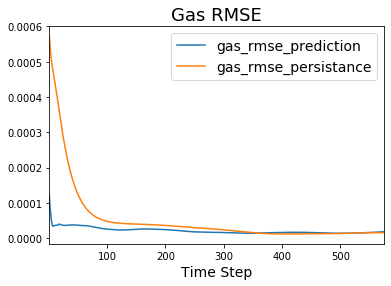

In [17]:
#Gas RMSE Plots
gas_columns = gas_output_data.columns[gas_output_data.columns.str.contains("Gas")]
total_gas_df = pd.DataFrame({"gas_total_output": gas_output_data[gas_columns].sum(axis = 1),
                             "gas_total_pred": gas_predict_data[gas_columns].sum(axis = 1),
                             "gas_total_persist": input_data[gas_columns].sum(axis = 1),
                             'timestep': gas_output_data.timestep})
total_gas_df["gas_rmse_prediction"] = (total_gas_df.gas_total_output - total_gas_df.gas_total_pred)**2
total_gas_df["gas_rmse_persistance"] = (total_gas_df.gas_total_output - total_gas_df.gas_total_persist)**2


gas_rmse_time = total_gas_df.groupby(by = 'timestep')[["gas_rmse_prediction", "gas_rmse_persistance"]].mean()**0.5
print(gas_rmse_time)

gas_rmse_time.plot()
plt.title("Gas RMSE", fontsize=18)
plt.xlabel("Time Step", fontsize=14)
plt.legend(fontsize=14)
plt.savefig("rmse_plot_gas_trial_%s.png" % trial_num, dpi=200, bbox_inches="tight")

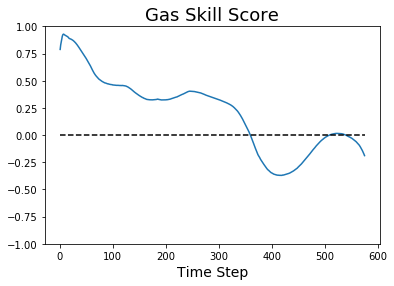

In [18]:
#Gas Skill Score
gas_rmse_time["gas_skill_score"] = (1 - (gas_rmse_time.gas_rmse_prediction / gas_rmse_time.gas_rmse_persistance))
plt.plot(gas_rmse_time.index , gas_rmse_time['gas_skill_score'])
plt.ylim(bottom = -1, top = 1)
plt.title("Gas Skill Score", fontsize=18)
plt.xlabel("Time Step", fontsize=14)
plt.plot(gas_rmse_time.index , np.zeros(gas_rmse_time.index.size), "k--")
plt.savefig("skill_plot_gas_trial_%s.png" % trial_num, dpi=200, bbox_inches="tight")

-2.216433476182383e-07
          gas_total_pred  gas_total_output
timestep                                  
1               0.000441          0.000462
2               0.000899          0.000913
3               0.001343          0.001345
4               0.001768          0.001764
5               0.002179          0.002173
...                  ...               ...
571             0.012043          0.012041
572             0.012030          0.012028
573             0.012017          0.012015
574             0.012005          0.012002
575             0.011992          0.011990

[575 rows x 2 columns]


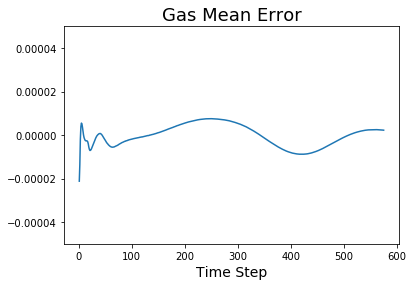

In [19]:
#Gas Mean Error

gas_mean_error = np.mean(gas_predict_data[gas_columns].sum(axis = 1) - gas_output_data[gas_columns].sum(axis = 1))
print(gas_mean_error)

gas_mean_df = total_gas_df.groupby(by = 'timestep')[["gas_total_pred", "gas_total_output"]].mean()
print(gas_mean_df)
gas_mean_df["gas_mean_error_pt"] = (gas_mean_df.gas_total_pred - gas_mean_df.gas_total_output)
plt.plot(gas_mean_df.index , gas_mean_df['gas_mean_error_pt'])
plt.ylim(bottom = -0.00005 , top = 0.00005)
plt.title("Gas Mean Error", fontsize=18)
plt.xlabel("Time Step", fontsize=14)
plt.savefig("mean_gas_trial_%s.png" % trial_num, dpi=200, bbox_inches="tight")

In [ ]:
# ~~Precursor Calculations ~~

In [20]:
pre_output_data = output_data[['Precursor [ug/m3]',
        'timestep']].copy()

In [21]:
pre_predict_data = prediction_data[['Precursor [ug/m3]',
        'timestep']].copy()

          precursor_rmse_prediction  precursor_rmse_persistance
timestep                                                       
1                          0.000038                    0.000434
2                          0.000031                    0.000427
3                          0.000029                    0.000420
4                          0.000028                    0.000414
5                          0.000028                    0.000407
...                             ...                         ...
571                        0.000025                    0.000014
572                        0.000025                    0.000014
573                        0.000025                    0.000014
574                        0.000025                    0.000014
575                        0.000025                    0.000014

[575 rows x 2 columns]


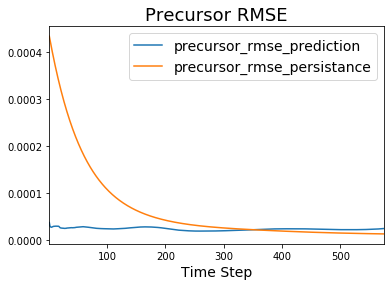

In [22]:
#Precursor RMSE Plots
pre_columns = pre_output_data.columns[pre_output_data.columns.str.contains("Precursor")]
total_pre_df = pd.DataFrame({"pre_total_output": pre_output_data[pre_columns].sum(axis = 1),
                             "pre_total_pred": pre_predict_data[pre_columns].sum(axis = 1),
                             "pre_total_persist": input_data[pre_columns].sum(axis = 1),
                             'timestep': pre_output_data.timestep})
total_pre_df["precursor_rmse_prediction"] = (total_pre_df.pre_total_output - total_pre_df.pre_total_pred)**2
total_pre_df["precursor_rmse_persistance"] = (total_pre_df.pre_total_output - total_pre_df.pre_total_persist)**2


pre_rmse_time = total_pre_df.groupby(by = 'timestep')[["precursor_rmse_prediction", "precursor_rmse_persistance"]].mean()**0.5
print(pre_rmse_time)

pre_rmse_time.plot()
plt.title("Precursor RMSE", fontsize=18)
plt.xlabel("Time Step", fontsize=14)
plt.legend(fontsize=14)
plt.savefig("rmse_plot_pre_trial_%s.png" % trial_num, dpi=200, bbox_inches="tight")


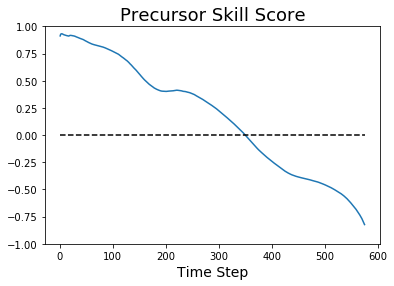

In [23]:
#Pre Skill Score
pre_rmse_time["pre_skill_score"] = (1 - (pre_rmse_time.precursor_rmse_prediction / pre_rmse_time.precursor_rmse_persistance))
plt.plot(pre_rmse_time.index , pre_rmse_time['pre_skill_score'])
plt.ylim(bottom = -1, top = 1)
plt.title("Precursor Skill Score", fontsize=18)
plt.xlabel("Time Step", fontsize=14)
plt.plot(pre_rmse_time.index , np.zeros(pre_rmse_time.index.size), "k--")
plt.savefig("skill_plot_pre_trial_%s.png" % trial_num, dpi=200, bbox_inches="tight")

3.508370934371383e-06
          pre_total_pred  pre_total_output
timestep                                  
1               0.037340          0.037332
2               0.036990          0.036980
3               0.036644          0.036633
4               0.036301          0.036291
5               0.035962          0.035953
...                  ...               ...
571             0.004620          0.004612
572             0.004611          0.004603
573             0.004603          0.004594
574             0.004594          0.004585
575             0.004585          0.004577

[575 rows x 2 columns]


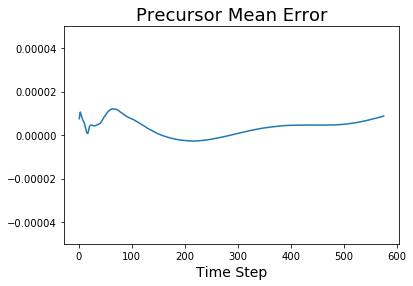

In [24]:
#Precursor Mean Error

pre_mean_error = np.mean(pre_predict_data[pre_columns].sum(axis = 1) - pre_output_data[pre_columns].sum(axis = 1))
print(pre_mean_error)

pre_mean_df = total_pre_df.groupby(by = 'timestep')[["pre_total_pred", "pre_total_output"]].mean()
print(pre_mean_df)
pre_mean_df["pre_mean_error_pt"] = (pre_mean_df.pre_total_pred - pre_mean_df.pre_total_output)
plt.plot(pre_mean_df.index , pre_mean_df['pre_mean_error_pt'])
plt.ylim(bottom = -0.00005 , top = 0.00005)
plt.title("Precursor Mean Error", fontsize=18)
plt.xlabel("Time Step", fontsize=14)
plt.savefig("mean_pre_trial_%s.png" % trial_num, dpi=200, bbox_inches="tight")

In [47]:
# ~~~~~~~~~~~~~~~~~~~~~~

In [ ]:
# Misc Calculations

In [116]:
#Aer Skill score

#difr = aer_predict_mean.sub(aer_output_mean)
#print(Sub)


RMSE = np.sqrt(np.mean((aer_predict_mean - aer_output_mean)**2))

RMSE_baseline = np.sqrt(np.mean((aer_output_mean.mean() - aer_output_mean)**2))

skill_score = 1 - (RMSE / RMSE_baseline)
print(skill_score)

#print(RMSE)
#print(RMSE_baseline)

Aerosol [ug_m3] Bin01: lg(C*) = -5.5    0.997882
Aerosol [ug_m3] Bin02: lg(C*) = -4.5    0.997696
Aerosol [ug_m3] Bin03: lg(C*) = -3.5    0.997946
Aerosol [ug_m3] Bin04: lg(C*) = -2.5    0.997899
Aerosol [ug_m3] Bin05: lg(C*) = -1.5    0.997774
Aerosol [ug_m3] Bin06: lg(C*) = -0.5    0.997580
Aerosol [ug_m3] Bin07: lg(C*) =  0.5    0.997938
Aerosol [ug_m3] Bin08: lg(C*) =  1.5    0.997695
Aerosol [ug_m3] Bin09: lg(C*) =  2.5    0.997342
Aerosol [ug_m3] Bin10: lg(C*) =  3.5    0.996794
Aerosol [ug_m3] Bin11: lg(C*) =  4.5    0.996713
Aerosol [ug_m3] Bin12: lg(C*) =  5.5    0.995036
Aerosol [ug_m3] Bin13: lg(C*) =  6.5    0.992655
Aerosol [ug_m3] Bin14: lg(C*) = -6.5    0.993041
dtype: float64


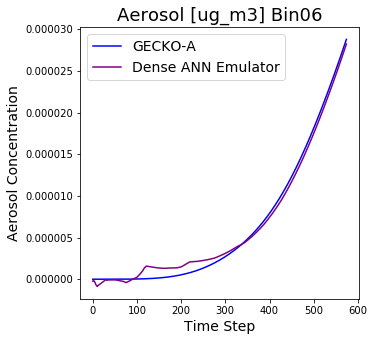

In [19]:
#Aerosol [ug_m3] Bin06
col2 = output_data.columns[output_data.columns.str.contains("Aerosol")][5]
plt.figure(figsize=(5, 5))
plt.plot(output_data.loc[:574, col2], color='blue', label="GECKO-A")
plt.plot(prediction_data.loc[:574, col2], color="purple", label="Dense ANN Emulator")
plt.title("Aerosol [ug_m3] Bin06", fontsize=18)
plt.ylabel("Aerosol Concentration", fontsize=14)
plt.xlabel("Time Step", fontsize=14)
plt.legend(fontsize=14)
#plt.savefig("plot3_Bin06_trial_%s.png" % trial, dpi=200, bbox_inches="tight")

In [115]:
# Skill Score Aerosol

aer_col1 = output_data.columns.str.contains("Aerosol")
aer_col2= prediction_data.columns.str.contains("Aerosol")
aer_output_dat_final= output_data.values[:, aer_col1]
aer_out_pred_final= prediction_data.values[:, aer_col2]
print(aer_output_dat_final.shape)
aer_final_mass_data = np.sum(aer_output_dat_final, axis=1)
aer_final_mass_pred = np.sum(aer_out_pred_final, axis=1)

print(aer_final_mass_data)

#aerosol_mass_RMSE = np.sqrt(np.square(np.subtract(aer_final_mass_data,aer_final_mass_pred)).mean())

RMSE = np.sqrt(np.mean((aer_final_mass_pred - aer_final_mass_data)**2))

RMSE_baseline = np.sqrt(np.mean((aer_final_mass_data.mean() - aer_final_mass_data)**2))

skill_score = 1 - (RMSE / RMSE_baseline)
print(skill_score)

print(RMSE)
print(RMSE_baseline)

(3105000, 14)
[2.76456438e-11 2.07512387e-10 8.41940970e-10 ... 1.53437691e-03
 1.54504734e-03 1.55580013e-03]
0.997627807376549
6.8779447946630535e-06
0.0028994040056735796


In [14]:
# Skill Score Gas

gas_col1 = output_data.columns.str.contains("Gas")
gas_col2= prediction_data.columns.str.contains("Gas")
gas_output_dat_final= output_data.values[:, gas_col1]
gas_out_pred_final= prediction_data.values[:, gas_col2]
print(gas_output_dat_final.shape)
gas_final_mass_data = np.sum(gas_output_dat_final, axis=1)
gas_final_mass_pred = np.sum(gas_out_pred_final, axis=1)

RMSE = np.sqrt(np.mean((gas_final_mass_pred - gas_final_mass_data)**2))

RMSE_baseline = np.sqrt(np.mean((gas_final_mass_data.mean() - gas_final_mass_data)**2))

skill_score = 1 - (RMSE / RMSE_baseline)
print(skill_score)

print(RMSE)
print(RMSE_baseline)

(3105000, 14)
0.9960187595869001
2.339144136711348e-05
0.005875415433377593


In [15]:
# Skill Score Precursor

pre_col1 = output_data.columns.str.contains("Precursor")
pre_col2= prediction_data.columns.str.contains("Precursor")
pre_output_dat_final= output_data.values[:, pre_col1]
pre_out_pred_final= prediction_data.values[:, pre_col2]
print(pre_output_dat_final.shape)
pre_final_mass_data = np.sum(pre_output_dat_final, axis=1)
pre_final_mass_pred = np.sum(pre_out_pred_final, axis=1)

RMSE = np.sqrt(np.mean((pre_final_mass_pred - pre_final_mass_data)**2))

RMSE_baseline = np.sqrt(np.mean((pre_final_mass_data.mean() - pre_final_mass_data)**2))

skill_score = 1 - (RMSE / RMSE_baseline)
print(skill_score)

print(RMSE)
print(RMSE_baseline)

(3105000, 1)
0.9972231825629976
3.249759454543541e-05
0.011703180091132201
